# Logistic regression pipelines for Pump It Up data

Data was prepped with data_prep.py

* got rid of a bunch of cols
* did a few data type changes

Before launching into this more complex example, should 

* numpy and pandas review
* create an sklearn review based on a simple regression model (using all or mostly numeric inputs). Can do basic data encoding, model building, model evaluation and maybe a simple pipeline.
* Should also provide some material on understanding regularization.
* Should also provide some material on understanding stochastic gradient descent - see https://realpython.com/gradient-descent-algorithm-python/.

Pipeline docs: https://scikit-learn.org/stable/modules/compose.html#
https://stackoverflow.com/questions/28822756/getting-model-attributes-from-scikit-learn-pipeline

Column transformers

* https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
* https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer
* https://scikit-learn.org/dev/auto_examples/compose/plot_column_transformer_mixed_types.html#use-columntransformer-by-selecting-column-by-names
* https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py

openml: https://scikit-learn.org/stable/datasets/loading_other_datasets.html#openml

## Preliminaries

In [1]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Import commonly used libraries and magic command for inline plotting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle


In [3]:
%matplotlib inline

## Load data from json

The Data_Prep notebook exported a json file. 

**TODO** - create small dataframe and explore the different json based representations of DataFrames that are possible with `to_json` and `read_json`.

In [4]:
train_X_prep = pd.read_csv('../data/train_x.csv')
train_y_prep = pd.read_csv("../data/raw/train_y.csv")
test_X_prep = pd.read_csv("../data/test_x.csv")





In [5]:
train_y_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [6]:
# drop id col
train_X = train_X_prep.iloc[:, 1:]
test_X = test_X_prep.iloc[:, 1:]
train_y = train_y_prep.iloc[:, 1]

In [7]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   num_private            59400 non-null  int64  
 7   basin                  59400 non-null  object 
 8   region                 59400 non-null  object 
 9   lga                    59400 non-null  object 
 10  population             59400 non-null  int64  
 11  public_meeting         59400 non-null  object 
 12  scheme_management      59400 non-null  object 
 13  permit                 59400 non-null  object 
 14  construction_year      59400 non-null  int64  
 15  ex

In [8]:
train_X.dtypes

amount_tsh               float64
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
num_private                int64
basin                     object
region                    object
lga                       object
population                 int64
public_meeting            object
scheme_management         object
permit                    object
construction_year          int64
extraction_type_class     object
management_group          object
payment_type              object
quality_group             object
quantity_group            object
source_class              object
waterpoint_type_group     object
dtype: object

In [9]:
categorical_cols_idx = [1, 3, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]

In [10]:
train_X.nunique()

amount_tsh                  98
funder                      11
gps_height                2428
installer                   11
longitude                57516
latitude                 57517
num_private                 65
basin                        9
region                      21
lga                        125
population                1049
public_meeting               3
scheme_management           10
permit                       3
construction_year           55
extraction_type_class        7
management_group             5
payment_type                 7
quality_group                6
quantity_group               5
source_class                 3
waterpoint_type_group        6
dtype: int64

In [11]:
train_X.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,lga,...,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group
0,6000.0,Other,1390,Other,34.938093,-9.856322,0,Lake Nyasa,Iringa,Ludewa,...,VWC,False,1999,gravity,user-group,annually,good,enough,groundwater,communal standpipe
1,0.0,Other,1399,Other,34.698766,-2.147466,0,Lake Victoria,Mara,Serengeti,...,Other,True,2010,gravity,user-group,never pay,good,insufficient,surface,communal standpipe
2,25.0,Other,686,Other,37.460664,-3.821329,0,Pangani,Manyara,Simanjiro,...,VWC,True,2009,gravity,user-group,per bucket,good,enough,surface,communal standpipe
3,0.0,Unicef,263,Other,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,Nanyumbu,...,VWC,True,1986,submersible,user-group,never pay,good,dry,groundwater,communal standpipe
4,0.0,Other,0,Other,31.130847,-1.825359,0,Lake Victoria,Kagera,Karagwe,...,missing,True,0,gravity,other,never pay,good,seasonal,surface,communal standpipe


## Data preprocessing

Get list of numeric cols and categorical cols to facilitate preprocessing.

FYI, Booleans in pandas show as object in `df.info()`. I converted the booleans to strings (ints are ok too) in `data_prep.py`.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [12]:
categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

all_cols = train_X.columns.tolist()


In [13]:
numeric_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year']

In [14]:
categorical_cols

['funder',
 'installer',
 'basin',
 'region',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_class',
 'waterpoint_type_group']

In [15]:
assert len(all_cols) == (len(categorical_cols) + len(numeric_cols))

In [16]:
all_cols

['amount_tsh',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'num_private',
 'basin',
 'region',
 'lga',
 'population',
 'public_meeting',
 'scheme_management',
 'permit',
 'construction_year',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_class',
 'waterpoint_type_group']

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV

In [18]:
train_X_cat = train_X.loc[:, categorical_cols]

In [19]:
train_X_cat.head()

,funder,installer,basin,region,lga,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group
0,Other,Other,Lake Nyasa,Iringa,Ludewa,True,VWC,False,gravity,user-group,annually,good,enough,groundwater,communal standpipe
1,Other,Other,Lake Victoria,Mara,Serengeti,missing,Other,True,gravity,user-group,never pay,good,insufficient,surface,communal standpipe
2,Other,Other,Pangani,Manyara,Simanjiro,True,VWC,True,gravity,user-group,per bucket,good,enough,surface,communal standpipe
3,Unicef,Other,Ruvuma / Southern Coast,Mtwara,Nanyumbu,True,VWC,True,submersible,user-group,never pay,good,dry,groundwater,communal standpipe
4,Other,Other,Lake Victoria,Kagera,Karagwe,True,missing,True,gravity,other,never pay,good,seasonal,surface,communal standpipe


In [20]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_X_cat_x = enc.fit_transform(train_X_cat)

In [21]:
train_X_cat_x.shape

(59400, 232)

## Logistic regression

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Different solvers support different regularization options. The 'saga' solver is the only that supports l1, l2, and elasticnet for multinomial setting for `multi-class` argument.

User Guide: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Our problem is:

* multiclass (not binomial) with three classes
* currently, all of the categorical data are strings

https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py

After exploring with the standard LogisticRegression function, could try the cross-validation version - [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) which searches over a grid of C values and l1 ratios (only applicable for elastic-net).

In sklearn 1.0dev, there's a new [ColumnTransformer with Mixed Types example](https://scikit-learn.org/dev/auto_examples/compose/plot_column_transformer_mixed_types.html). It's very similar to what we want to do here. Since we are doing regularized logistic regression, the numeric vars should be rescaled. The example uses pipelines and various preprocessing steps. ColumnTransformer exists now, it just looks like a new example. Here's an example from current version: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html#sphx-glr-auto-examples-compose-plot-column-transformer-py. In the new example shows printing out html version of pipeline.

Example goes on to show how to use `make_column_selector` to do automatic segregation of numeric and categorical columns.

Another example with some neat code for automatically creating lists of various types of features
* https://www.kaggle.com/kylegilde/building-columntransformers-dynamically


In [22]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=1, solver='saga', max_iter=1000, verbose=1))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 87 seconds
model score: 0.746


C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


Coefficients aren't converging. Tried up to `max_iter=400`. Might be some multicollinearity in the categoricals. Nevertheless, getting 0.746 accuracy level on test. This value is pretty stable no matter what I try for `max_iter`. Got same results with setting `C=1+e2`. Let's try $C<1$. Then let's try `LogisticRegressionCV`. Could check the correlation matrix of the one hot encoded array.

In [23]:
numeric_transformer = StandardScaler()
# Don't need to drop one dummy since no matrix inversion in logistic regression
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_en = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='elasticnet', C=1, l1_ratio=0.5, solver='saga', max_iter=1000))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf_en.fit(X_train, y_train)
print("model score: %.3f" % clf_en.score(X_test, y_test))

model score: 0.746


C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Got convergence and same accuracy (0.747) for C=0.1 and max_iter=1000. Below I used LogisticRegressionCV and it found optimal C=10. Let's try that above. RESULT: Does not converge for C=0. Slightly lower accuracy (0.745).

https://stackoverflow.com/questions/45850841/does-sklearn-linear-model-logisticregression-always-converge-to-best-solution

https://datascience.stackexchange.com/questions/77813/logistic-regression-does-cannot-converge-without-poor-model-performance

**TODO** BTW, both sag and saga use a variant of stochastic gradient descent. Would be a nice idea to cover this general algorithm - see Data Science from Scratch or some other enlightening implementation for learning purposes. Getting a sense of how this algorithm works should make you a better sklearn modeler since its often used in various optimization algos for fitting.

Detailed SO post on logistic regression solvers: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions/52388406#52388406

https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451



> You can compute VIF by inverting correlation matrix and taking the diagonals.

https://realpython.com/numpy-scipy-pandas-correlation-python/

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

If we try to allocate non-sparse X matrix (containing the one hot encoded values), we get a memory error. **WRONG** I didn't look closely at the doc for `np.corrcoef`. The rows are vars. Need to transpose

```
Parameters

    xarray_like

        A 1-D or 2-D array containing multiple variables and observations. Each row of x represents a variable, and each column a single observation of all those variables. 
```

https://stackoverflow.com/questions/19231268/correlation-coefficients-for-sparse-matrix-in-python

In [24]:
# Compute correlation matrix and VIFs of one hot encoded categorical variables
# WAIT, can't do this unless we change encoding to drop one dummy

enc = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
train_X_cat_x = enc.fit_transform(train_X_cat)

corr_cats = np.corrcoef(np.transpose(train_X_cat_x))
inv_corr_cats = np.linalg.inv(corr_cats)

# VIF is diag of inv_corr_cats
vif = np.diagonal(inv_corr_cats)
vif.shape

(217,)

Hmm, plot below showing negative values. If you look at matrix there are crazy big values.

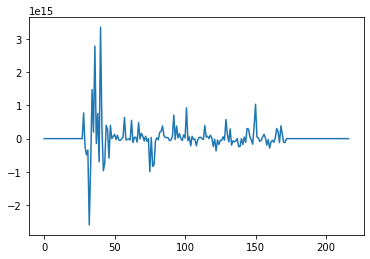

In [25]:
plt.plot(vif)

In [26]:
vif

array([ 8.09063607e+00,  3.51896675e+00,  4.82017222e+00,  1.23175089e+01,
        2.99898356e+00,  1.74378412e+00,  2.02395405e+00,  2.33360737e+00,
        2.40799038e+00,  3.51457040e+01,  5.13505882e+01,  4.71528796e+01,
        5.35696372e+02,  7.84590020e+01,  3.85990516e+01,  4.34103406e+01,
        6.46094212e+02,  5.26702250e+01,  3.16552470e+01,  1.68117447e+02,
        1.75845261e+01,  7.51646316e+00,  1.18313393e+01,  1.40949485e+01,
        1.45455033e+01,  2.03034255e+01,  2.10376136e+01,  1.62744097e+01,
        7.74630722e+14, -2.46137548e+14, -4.87365384e+14, -3.41786124e+14,
       -2.59747727e+15, -7.83354555e+14,  1.47360351e+15,  1.96205890e+14,
        2.78210840e+15, -1.47455676e+14,  7.56923416e+14, -6.98632833e+14,
        3.35249991e+15,  3.32512957e+14, -9.66549296e+14, -7.27434339e+14,
        3.99658486e+14,  2.72355988e+14, -5.90167618e+14,  3.98476077e+14,
        1.38444870e+00,  6.45105414e+13,  1.29458683e+14, -2.59161353e+13,
        1.01021601e+14, -

What do the coefficients look like?

https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

Can also try L1 to drive more coeffs to 0.

In [27]:
clf.named_steps['classifier'].coef_.shape

(3, 239)

One row per y variable outcome class.

In [28]:
clf.named_steps['classifier'].coef_

array([[ 3.23035906e-02, -1.36237711e-02,  1.82298721e-02,
        -1.06518052e-01, -8.75393264e-03,  5.36894788e-02,
         1.34953045e-02, -8.12652083e-02, -9.32726598e-02,
        -1.87653980e-01, -1.03423974e-02,  1.97016816e-01,
         3.36157304e-01,  7.49528602e-02, -5.86572887e-02,
        -1.39760004e-02,  2.76852383e-02,  1.96889379e-01,
         4.25797316e-01,  1.08274008e-01,  1.93264403e-01,
        -1.74133572e-02, -2.88260384e-01,  2.01325641e-01,
        -2.02418734e-01,  1.29385525e-01, -4.75950674e-01,
         1.14872012e-01,  1.98658307e-01,  1.04216033e-01,
         3.08381231e-01,  1.12436787e-02,  2.42577988e-01,
         2.29318203e-01, -6.35357698e-02, -2.48756425e-02,
        -1.04193698e-01, -3.15597960e-01,  2.70937983e-01,
         2.82388660e-01,  2.65038367e-01,  6.91168764e-01,
        -1.31028500e-01, -3.87119066e-01,  2.15082857e-01,
        -5.02396623e-01,  1.63650921e-01, -3.13160559e-01,
        -1.33834180e-01,  5.94089036e-02, -5.44129912e-0

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=1000, verbose=1))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf_lr.fit(X_train, y_train)
print("model score: %.3f" % clf_lr.score(X_test, y_test))

Below is a CV based example. FYI, there is also way to include parameters anywhere in the pipeline for a grid search. GridSearchCV.
See https://scikit-learn.org/dev/auto_examples/compose/plot_column_transformer_mixed_types.html. Also see section on automatic col detection.

In [30]:
# CV example
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegressionCV(solver='saga'))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: Convergenc

model score: 0.746


C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [31]:
clf.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['amount_tsh', 'gps_height', 'longitude',
                                     'latitude', 'num_private', 'population',
                                     'construction_year']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['funder', 'installer', 'basin', 'region',
                                     'lga', 'public_meeting', 'scheme_management',
                                     'permit', 'extraction_type_class',
                                     'management_group', 'payment_type',
                                     'quality_group', 'quantity_group',
                                     'source_class', 'waterpoint_type_group'])])),
  ('classifier', LogisticRegressionCV(solver='saga'))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', S

Looks like optimal C is 10, which means little regularization.

Example of using `make_pipeline` convenience function. Notice that steps get automatic names.

In [32]:
categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

clf2 = make_pipeline(ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)]),
                   LogisticRegressionCV(solver='saga'))

clf2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'construction_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['funder', 'installer',
                                                   'basin', 'region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit',
                                                   'extraction_type_class',
  

In [33]:
# This is from the new 1.0 ColumnTransformer example. 
from sklearn import set_config

set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'construction_year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['funder', 'installer',
                                                   'basin', 'region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit',
                                                   'extraction_type_class',
                                                   'management_group',
                                                   'payment_type',
                                                   'quality_group',
                                                   'quantity_group',
                                                   'source_class',
                                                   'waterpoint_type_group'])])),
                ('classifier', LogisticRegressionCV(solver='saga'))])

Above I use pipelines. What would that look like for a simple non pipeline approach.

In [34]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

preprocessor.fit(train_X)

train_X_pp = preprocessor.transform(train_X)

X_train, X_test, y_train, y_test = train_test_split(train_X_pp, train_y, test_size=0.2,
                                                    random_state=0)

# 1. Create model
logistic_1 = LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=1000)

# 2. Fit model
logistic_1.fit(X_train, y_train)

# 3. Predict using test data
logistic_1_cls = logistic_1.predict(X_test)

# 4. Score predictions
print("model score: %.3f" % logistic_1.score(X_test, y_test))

model score: 0.746


In [35]:
logistic_1_cls

array(['functional', 'non functional', 'non functional', ...,
       'functional', 'non functional', 'functional'], dtype=object)

In [36]:
np.unique(logistic_1_cls, return_counts=True)

(array(['functional', 'functional needs repair', 'non functional'],
       dtype=object),
 array([7937,  177, 3766], dtype=int64))

Let's make predictions on the real context `test_X` data.

In [37]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

preprocessor2.fit(test_X)
test_X_pp = preprocessor2.transform(test_X)
logistic_1_cls_test = logistic_1.predict(test_X_pp)

In [38]:
np.unique(logistic_1_cls_test, return_counts=True)

(array(['functional', 'functional needs repair', 'non functional'],
       dtype=object),
 array([9953,  208, 4689], dtype=int64))

In [40]:
submit_dict = {'id': test_X_prep['id'],
              'status_group': logistic_1_cls_test}
logistic_1_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])

In [41]:
logistic_1_submission

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [43]:
logistic_1_submission.to_csv('../output/logistic_1_submission.csv', index=False)

```
0.7428 	misken 	2021-03-16 15:40:36 UTC 
```

Not as good as simple random forest (0.8061) I used based on data prep done for pcda HW4 last year. Note that performance on test only a little worse than performance on train.

### LogisticRegressionCV

Try separate CV fits for each of the three penalties: l1, l2, elasticnet. Taking the default C leads to grid in powers of 10 [1e-1, 1e+4]. for ElasticNet we can also search over the l1_ratio [0, 1]. See the script, `logistic.py`. The results were dumped to a pickle file, `output/models_cls.pkl`. Let's explore the relative performance as well as the values of the coefficients to see how regularization impacts them.

In [44]:
with open("../output/models_clf.pkl", "rb") as model_file:
    models_clf = pickle.load(model_file)

In [45]:
dir(models_clf)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [46]:
type(models_clf)

dict

In [47]:
models_clf.keys()

dict_keys(['l1', 'l2', 'elasticnet'])

In [48]:
model_l1 = models_clf['l1']
model_l2 = models_clf['l2']
model_elasticnet = models_clf['elasticnet']

In [49]:
type(model_l1)

sklearn.pipeline.Pipeline

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [50]:
dir(model_l1)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transform',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_tr

In [51]:
# Get target classes
model_l1.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

Need to create small examples for each of these methods to see exactly what they do.

In [52]:
# Various methods for using the pipeline. See API docs.
model_l1.decision_function
model_l1.fit
model_l1.fit_transform
model_l1.fit_predict

model_l1.predict
model_l1.predict_log_proba
model_l1.predict_proba

model_l1.score
model_l1.score_samples

model_l1.transform

AttributeError: 'LogisticRegressionCV' object has no attribute 'fit_predict'

In [53]:
# See details of the pipeline
model_l1.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['funder', 'installer', 'basin', 'region',
                                     'lga', 'public_meeting', 'scheme_management',
                                     'permit', 'extraction_type_class',
                                     'management_group', 'payment_type',
                                     'quality_group', 'quantity_group',
                                     'source_class', 'waterpoint_type_group']),
                                   ('num', StandardScaler(),
                                    ['id', 'amount_tsh', 'gps_height', 'longitude',
                                     'latitude', 'num_private', 'population',
                                     'construction_year'])])),
  ('classifier',
   LogisticRegressionCV(Cs=[0.1, 1, 10], l1_ratios=[0.0, 0.25, 0.5, 0.75, 1.0],
                        max_it

We need to go into `steps` to see things like cofficients

In [54]:
# steps is a list of step tuples
model_l1.steps

[('preprocessor',
  ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                   ['funder', 'installer', 'basin', 'region',
                                    'lga', 'public_meeting', 'scheme_management',
                                    'permit', 'extraction_type_class',
                                    'management_group', 'payment_type',
                                    'quality_group', 'quantity_group',
                                    'source_class', 'waterpoint_type_group']),
                                  ('num', StandardScaler(),
                                   ['id', 'amount_tsh', 'gps_height', 'longitude',
                                    'latitude', 'num_private', 'population',
                                    'construction_year'])])),
 ('classifier',
  LogisticRegressionCV(Cs=[0.1, 1, 10], l1_ratios=[0.0, 0.25, 0.5, 0.75, 1.0],
                       max_iter=200, penalty='l1', solver='saga'))]

In [55]:
# This should be label of first step (zero index)
model_l1.steps[0][0]

'preprocessor'

In [56]:
dir(model_l1.steps[1][1])

['C_',
 'Cs',
 'Cs_',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'coefs_paths_',
 'cv',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio_',
 'l1_ratios',
 'l1_ratios_',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 '

In [57]:
model_l1.steps[1][1].C_

array([1., 1., 1.])

In [58]:
model_l2.steps[1][1].C_

array([10., 10., 10.])

In [59]:
model_elasticnet.steps[1][1].C_

array([1., 1., 1.])

In [60]:
model_elasticnet.steps[1][1].l1_ratio_

array([1., 1., 1.])

From above we see that an `l1_ratio_` of 1 in elastic-net means it's doing l1 regularization (lasso). Similarly, C=10 for l2 means low regularization.

Let's adapt JVP's `basis_plot` function from the 05.06-Linear-Regression notebook.

In [61]:
def coef_plot(model, title=None):
    fig, ax = plt.subplots(3, sharex=True)
       
    if title:
        ax[0].set_title(title)

    for i in range(3):
        ax[i].plot(model.steps[1][1].coef_[i])


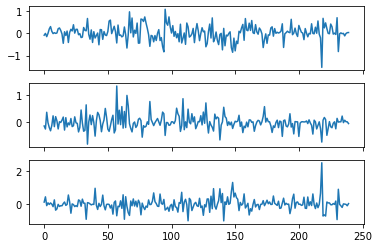

In [62]:
coef_plot(model_l1)

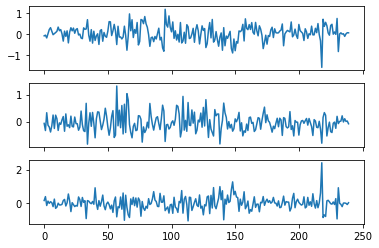

In [63]:
coef_plot(model_l2)

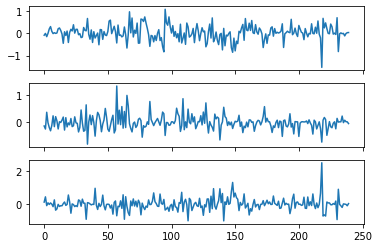

In [64]:
coef_plot(model_elasticnet)

Let's do l2 and force high regularization to see if coefficients change.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 47 epochs took 4 seconds
model score: 0.721


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


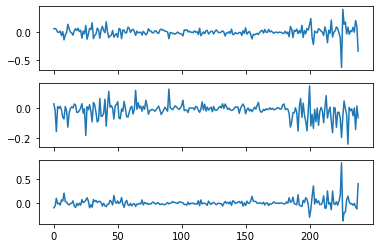

In [65]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_l2_hireg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2', C=0.001, solver='saga', max_iter=1000, verbose=1))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf_l2_hireg.fit(X_train, y_train)
print("model score: %.3f" % clf_l2_hireg.score(X_test, y_test))
coef_plot(clf_l2_hireg)

## Beyond logistic regression

Let's try some more techniques and get more practice with sklearn pipelines. Then we could bake them all together into an ensemble which would make a nice wrap up of this module. Possibilities include:

* LightGBM - a boosted tree instead of a bagged tree (e.g. Random Forest)
* could try Random Forest with one hot encoded data (have R based performance already)

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier

* https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt

* https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py

* https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py

### HistGradientBoostingClassifier

In [66]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [67]:
categorical_cols

['funder',
 'installer',
 'basin',
 'region',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_class',
 'waterpoint_type_group']

The reason that below was failing is that the preprocessor reorders columns in the order implied by the transformers. So, then categorical_cols_idx is wrong because it's based on the original ordering.

* Does HistGradientBoostingClassifier() want ordinal categoricals to be ordered by group size? 
    - internally it sorts them by their variance which then allows efficient partitioning (see https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt)

* How does the OrdinalEncoder assign ordered integers?

Also, seems like we can actually keep 'id' around and let the ColumnTransformer drop it.

In [68]:
train_X = pd.read_csv('../data/train_x.csv')
train_y_raw = pd.read_csv("../data/raw/train_y.csv")
test_X = pd.read_csv("../data/test_x.csv")

# Drop id from train_y_raw
train_y = train_y_raw.iloc[:, 1]

categorical_cols = train_X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_X.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('id')

In [70]:
numeric_transformer = StandardScaler()
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)],
        remainder='drop')

# The preprocessor reorders the columns into blocks by type as defined by the transformers. So, now
# the categorical cols are the first columns. We need their index numbers to use in the call to the
# HistGradientBoostingClassifier() so it knows which cols to treat as categoricals (even though they
# have been transformed into meaningless integers.)

categorical_cols_idx = [_ for _ in range(len(categorical_cols))]

# Append classifier to preprocessing pipeline.
clf_hgbc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier(categorical_features=categorical_cols_idx))])

# Partition data
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)
# Fit model
clf_hgbc.fit(X_train, y_train)
print("model score: %.3f" % clf_hgbc.score(X_test, y_test))

# Can just do the prediction using test data and predict will send it through the pipeline for preprocessing.
clf_hgbc_test = clf_hgbc.predict(test_X)

# Create submission file 
submit_dict = {'id': test_X['id'],
              'status_group': clf_hgbc_test}

hgbc_1_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])
hgbc_1_submission.to_csv('../output/hgbc_1_submission.csv', index=False)


model score: 0.792


In [71]:
# Can just do the prediction using test data and predict will send it through the pipeline for preprocessing.
clf_hgbc_test = clf_hgbc.predict(test_X)

In [73]:
submit_dict = {'id': test_X_prep['id'],
              'status_group': clf_hgbc_test}
hgbc_1_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])
hgbc_1_submission.to_csv('../output/hgbc_1_submission.csv', index=False)

Well, hgbc did better than logistic, test = 0.7713. Still not as good as first random forest done with R.

Let's look at confusion matrix to see where we are making mistakes.
https://scikit-learn.org/stable/visualizations.html#visualizations


In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Getting fitted values - just predict on training data

In [75]:
clf_hgbc.predict(train_X)

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype=object)

Accessing attributes of steps in pipeline

In [76]:
clf_hgbc['classifier'].classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

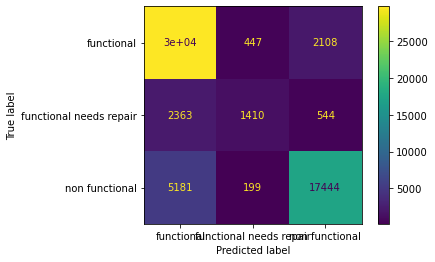

In [77]:
plot_confusion_matrix(clf_hgbc, train_X, train_y, labels=clf_hgbc['classifier'].classes_)

### Random forest

Need to one hot encode. Can lead to huge trees requiring many splits.

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
# I'm repeating the transformer here but not needed
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(oob_score=True, random_state=0))])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

clf_rf.fit(X_train, y_train)
print("model score: %.3f" % clf_rf.score(X_test, y_test))

model score: 0.796


In [81]:
# Can just do the prediction using test data and predict will send it through the pipeline for preprocessing.
clf_rf_test = clf_rf.predict(test_X)

# Create submission file 
submit_dict = {'id': test_X_prep['id'],
              'status_group': clf_rf_test}

clf_rf_1_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])
clf_rf_1_submission.to_csv('../output/clf_rf_1_submission.csv', index=False)

This submission got a score of 0.8055 which was extremely close to the R based rf predictions.

## Ensemble

In [82]:
from sklearn.ensemble import VotingClassifier

In [84]:
# 1. Create model
ensemble_1 = VotingClassifier(estimators=[('clf_lr', clf_lr),
                                          ('clf_hgbc', clf_hgbc),
                                          ('clf_rf', clf_rf)], 
                              voting='soft', weights=[1.0, 1.0, 1.0])

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2,
                                                    random_state=0)

# 2. Fit model
ensemble_1.fit(X_train, y_train)
print(f"Score: {ensemble_1.score(X_test, y_test):.4f}")

# Can just do the prediction using test data and predict will send it through the pipeline for preprocessing.
clf_ensemble_1_test = ensemble_1.predict(test_X)

# Create submission file 
submit_dict = {'id': test_X_prep['id'],
              'status_group': clf_ensemble_1_test}

clf_ensemble_1_submission = pd.DataFrame(submit_dict, columns=['id', 'status_group'])
clf_ensemble_1_submission.to_csv('../output/clf_ensemble_1_submission.csv', index=False)

C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_logistic.py:1807: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratios parameter is only used when penalty "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\isken\Anaconda3\envs\aap\lib\site-packages\sklearn\linear_model

KeyboardInterrupt: 